In [1]:
import re
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.errors import SettingWithCopyWarning
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


In [44]:
from sklearn.manifold import TSNE

strategies = ['None', 'Specific', 'Generic']
temperatures = ['0.0', '0.7']
variations = ['0', '1', '2']
recursions = ['0', '1']

regex_patterns = {
    'Powderkg': r'Powderkg = (\d+)',
    'wc': r'wc = ([\d.]+)',
    'materials': r'materials = ([\d./]+)',
    'curing': r'curing = (.+)$'
}


def find_explained_variance_using_pca(correlation_matrix, feature, strategy, temperature):
    pca = PCA(n_components=1)
    data = pd.DataFrame(correlation_matrix)
    pca.fit(data)
    # Get the first principal component
    first_principal_component = pca.components_[0]
    # Print the explained variance ratio, which tells you the proportion of variance
    # explained by the first principal component.
    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained Variance Ratio for {feature}, {strategy} and {temperature}:", explained_variance_ratio)
    # Print the first principal component, which represents the overall relationship
    print(f"First Principal Component (Overall Relationship) for {feature}, {strategy} and {temperature}:",
          first_principal_component)


def perform_correlation_analysis(feature, strategy, temperature, variation, recursion):
    correlation_matrix = df.corr()
    correlation_matrix = correlation_matrix.apply(lambda x: round(x, 2))
    average_cc_per_run = correlation_matrix.mean()
    correlation_matrix['Average Correlation'] = average_cc_per_run
    print('AVERAGE CORRELATION COEFFICIENT PER RUN')
    print(average_cc_per_run)
    overall_average_cc = correlation_matrix.stack().mean()
    print('OVERALL CORRELATION COEFFICIENT')
    print(overall_average_cc)
    # NaNs occur when the std is 0, i.e. we have constant functions. We handle this cas by replacing NaN with 1
    correlation_matrix.fillna(1, inplace=True)
    correlation_matrix.to_csv(
        f'Results/Correlation_Analysis/correlation_matrix_{feature}_{strategy}_{variation}_{temperature}_{recursion}.csv')
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    # Customize the plot (add labels, title, etc. if needed)
    plt.title(f'Correlation Heatmap {strategy} {temperature}')
    # plt.show()
    plt.savefig(
        f'Results/Correlation_Analysis/images/correlation_matrix_{feature}_{strategy}_{variation}_{temperature}_{recursion}.png',
        bbox_inches='tight')
    return correlation_matrix


def plot_individual_experiments(feature, strategy, temperature):
    plt.figure(figsize=(8, 6))
    plt.plot(df.index, df[f'{feature} 1'], label=f'{feature} Experiment 1')
    plt.plot(df.index, df[f'{feature} 2'], label=f'{feature} Experiment 2')
    plt.plot(df.index, df[f'{feature} 3'], label=f'{feature} Experiment 3')
    plt.legend()
    plt.title(f'Lineplot for {strategy} and {temperature}')
    plt.xlabel(feature)
    plt.tight_layout()
    plt.show()


def extract_data_for_given_run(pattern):
    matching_filenames = []
    # Iterate through the files in the directory
    dir_name = 'Results/ID'
    for filename in os.listdir(dir_name):
        match = re.match(pattern, filename)
        if match:
            matching_filenames.append(os.path.join(dir_name, filename))
    all_results_df = pd.DataFrame()
    warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
    for i, filename in enumerate(matching_filenames):
        results_sample_df = pd.read_csv(filename)
        results_sample_df.head(2)
        for col, pattern in regex_patterns.items():
            all_results_df[f'{col} {i}'] = results_sample_df['Formulation'].str.extract(pattern, expand=False)
            if col.startswith('materials'):
                all_results_df[f'{col} {i}'] = all_results_df[f'{col} {i}'].str[:3].astype(float)
            if col.startswith('curing'):
                all_results_df[f'{col} {i}'][all_results_df[f'{col} {i}'].astype(str).str.startswith('Heat')] = 0
                all_results_df[f'{col} {i}'][all_results_df[f'{col} {i}'].astype(str).str.startswith('heat')] = 0
                all_results_df[f'{col} {i}'][all_results_df[f'{col} {i}'].astype(str).str.startswith('Ambient')] = 1
                all_results_df[f'{col} {i}'][all_results_df[f'{col} {i}'].astype(str).str.startswith('ambient')] = 1
    return all_results_df, matching_filenames


def tsne_for_feature(feature, strategy, temperature):
    X_2d = tsne.fit_transform(df_transpose)
    # Create a scatter plot of the t-SNE results
    plt.figure(figsize=(8, 6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c='r', marker='o', label=feature)
    plt.title(f"t-SNE Visualization {strategy} {temperature}")
    plt.legend()
    plt.show()


def tsne_for_all_features(all_features_for_tsne, strategy, temperature):
    scaler = MinMaxScaler()
    scaler.fit(all_features_for_tsne)
    # Transform your DataFrame to apply the scaling
    scaled = pd.DataFrame(scaler.transform(all_features_for_tsne))
    tsne = TSNE(n_components=2, perplexity=2, random_state=0)
    X_2d = tsne.fit_transform(scaled)
    # Create a scatter plot of the t-SNE results
    plt.figure(figsize=(8, 6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c='r', marker='o', label='All Features')
    plt.title(f"t-SNE Visualization all features {strategy} {temperature}")
    plt.legend()
    plt.show()


def pca_and_corr_on_all_features(df):
    correlation_matrix = df.corr()
    correlation_matrix = correlation_matrix.apply(lambda x: round(x, 8))
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    # Customize the plot (add labels, title, etc. if needed)
    plt.title('Correlation Heatmap between Lineplots')
    plt.show()
    pca = PCA(n_components=1)
    data = pd.DataFrame(correlation_matrix)
    pca.fit(data)
    # Get the first principal component
    first_principal_component = pca.components_[0]
    # Print the explained variance ratio, which tells you the proportion of variance
    # explained by the first principal component.
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained Variance Ratio:", explained_variance_ratio)
    # Print the first principal component, which represents the overall relationship
    print("First Principal Component (Overall Relationship):", first_principal_component)

In [3]:
from itertools import product

all_combinations = list(product(strategies, variations, temperatures, recursions))

#### Correlation Analyses between different runs

In [ ]:
for combination in all_combinations:
    strategy = combination[0]
    variation = combination[1]
    temperature = combination[2]
    recursion = combination[3]
    print('#####################################################################################')
    print(
        f'################ Run with strategy {strategy}, variation {variation}, temperature {temperature} and recursion {recursion} ####################')
    print('#####################################################################################')
    pattern = fr'gpt-3.5-turbo_{strategy} {variation}_prompt_experiment_(\d+)_temp_{temperature}_target_(\d+)_\%_Dev_Budget_(\d+)_recursive_{recursion}_(\d+)\.csv'
    all_results_df, matching_filenames = extract_data_for_given_run(pattern)

    warnings.filterwarnings("default")

    features = ['Powderkg', 'wc', 'materials']
    for feature in features:
        print(f'################ Feature {feature} ################')
        data = {}
        for i in range(len(matching_filenames)):
            data[f'{feature} {i}'] = list(all_results_df[f'{feature} {i}'].values)

        df = pd.DataFrame(data)
        correlation_matrix = perform_correlation_analysis(feature, strategy, temperature, variation, recursion)
        # plot_individual_experiments(feature, strategy, temperature)
        find_explained_variance_using_pca(correlation_matrix, feature, strategy, temperature)

        tsne = TSNE(n_components=2, perplexity=2, random_state=0)
        df_transpose = df.T
        if feature == 'Powderkg':
            all_features_for_tsne = df_transpose.values
        else:
            all_features_for_tsne = np.hstack((all_features_for_tsne, df_transpose.values))
        # Comment in in case you want to have a tsne visualisation
        # tsne_for_feature(feature, strategy, temperature)

    # Comment in in case you want to have a tsne visualisation
    # tsne_for_all_features(all_features_for_tsne, strategy, temperature)

    df = pd.DataFrame(all_features_for_tsne).T
    df.head(30)

    scaler = MinMaxScaler()
    scaler.fit(df)

    # Transform your DataFrame to apply the scaling
    scaled_df = pd.DataFrame(scaler.transform(df), columns=df.columns)

    plt.plot(scaled_df.index, scaled_df[1].astype(str))
    plt.plot(scaled_df.index, scaled_df[2].astype(str))
    plt.gca().invert_yaxis()
    plt.show()

    # pca_and_corr_on_all_features(df)

#### Distribution analysis

#####################################################################################
####### Run with strategy None, variation 0, temperature 0.0 and recursion 0 #########
#####################################################################################
          0  1  2  3  4  5  6  7  8  9
curing 0  1  0  0  0  1  1  0  1  1  0
curing 1  1  0  0  0  1  0  1  1  0  1
curing 2  1  0  0  0  1  1  0  0  0  1
curing 3  1  0  0  0  1  1  0  0  0  1
curing 4  1  0  0  0  1  1  0  0  1  0


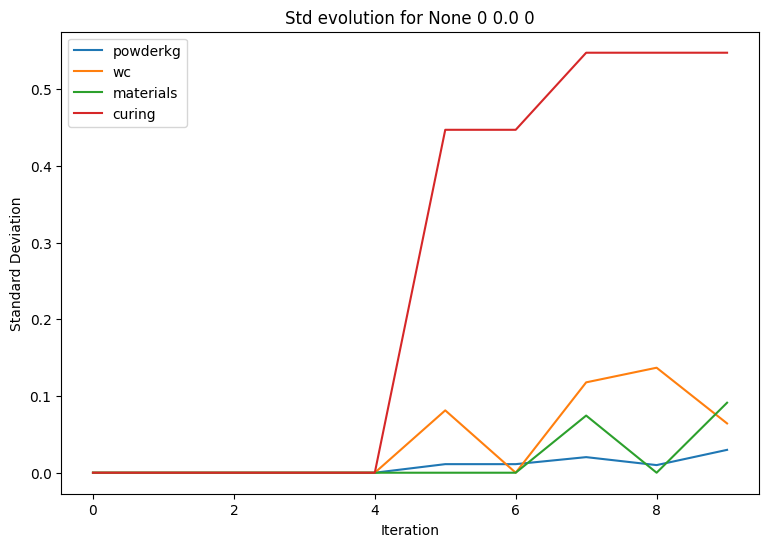

#####################################################################################
####### Run with strategy None, variation 0, temperature 0.0 and recursion 1 #########
#####################################################################################
          0  1  2  3  4  5  6  7  8  9
curing 0  0  0  0  0  1  0  0  0  0  0
curing 1  0  0  0  0  1  0  0  0  1  0
curing 2  1  0  1  1  1  0  0  1  0  1
curing 3  1  0  1  1  1  0  0  0  1  1
curing 4  1  0  1  1  1  0  0  0  1  1


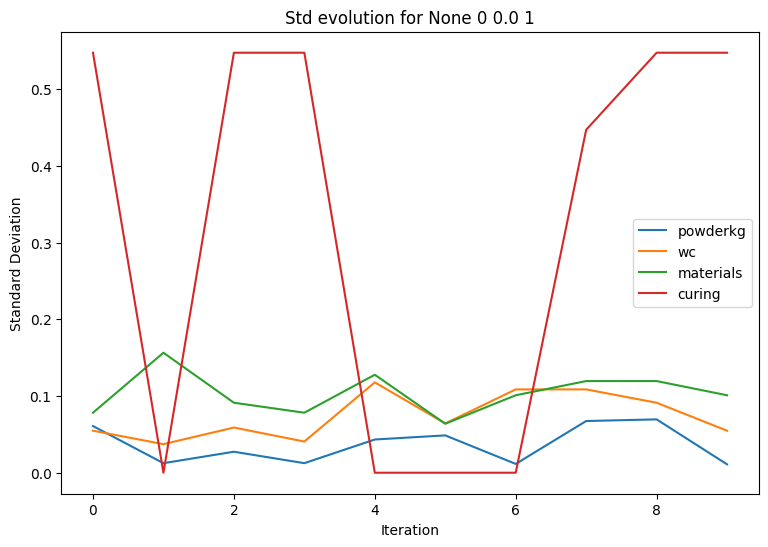

#####################################################################################
####### Run with strategy None, variation 0, temperature 0.7 and recursion 0 #########
#####################################################################################
          0  1  2  3  4  5  6  7  8  9
curing 0  1  0  1  0  0  1  0  1  0  0
curing 1  1  0  1  0  1  0  0  0  0  1
curing 2  1  0  0  0  1  1  0  0  0  1
curing 3  1  0  0  1  1  0  0  0  1  0
curing 4  1  0  0  0  1  0  1  1  0  1


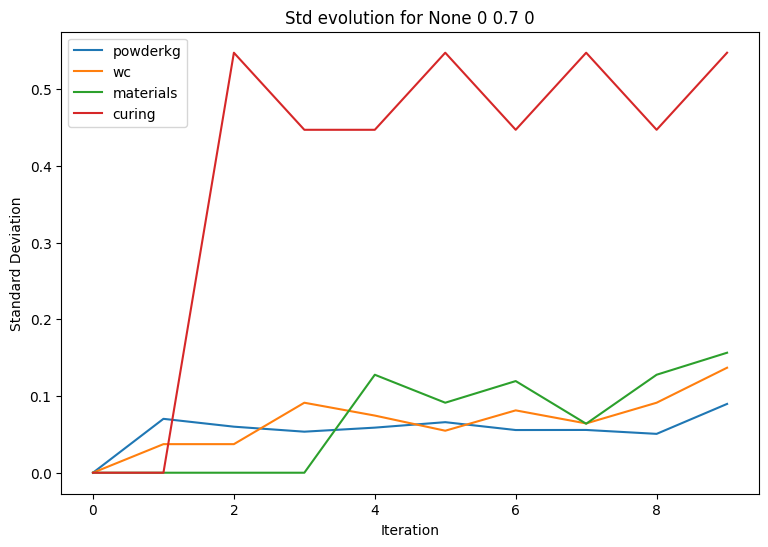

#####################################################################################
####### Run with strategy None, variation 0, temperature 0.7 and recursion 1 #########
#####################################################################################
          0  1  2  3  4  5  6  7  8  9
curing 0  0  0  0  0  1  0  0  0  0  0
curing 1  0  0  0  0  0  0  0  0  0  1
curing 2  0  0  1  0  1  0  0  0  0  0
curing 3  0  0  0  0  0  1  0  0  0  0
curing 4  0  0  0  1  0  0  0  0  0  0


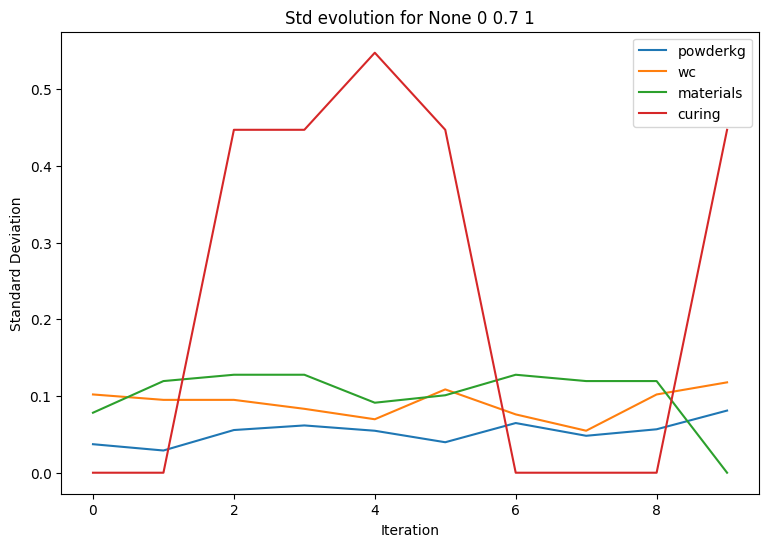

In [60]:
from sklearn.preprocessing import StandardScaler


# TODO: Refactor and detailed analysis for all 'rounds' (currently we only inspect the first round for all the experiments)

def plot_distribution(df):
    print(df)
    plt.hist(df[0], bins=10, color='skyblue', edgecolor='black')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of Values')
    plt.grid(True)
    plt.show()


def compute_std_over_different_runs(df):
    df = df.copy()
    std_for_each_run = []
    for i in range(10):
        max = df[i].astype(float).max()
        if max == 0:
            max = 1
        std = df[i].astype(float).std() / max
        std_for_each_run.append(std)
    return std_for_each_run


for combination in all_combinations[:4]:
    strategy = combination[0]
    variation = combination[1]
    temperature = combination[2]
    recursion = combination[3]

    pattern = fr'gpt-3.5-turbo_{strategy} {variation}_prompt_experiment_(\d+)_temp_{temperature}_target_(\d+)_\%_Dev_Budget_(\d+)_recursive_{recursion}_(\d+)\.csv'
    all_results_df, matching_filenames = extract_data_for_given_run(pattern)

    warnings.filterwarnings("default")

    print('#####################################################################################')
    print(f'####### Run with strategy {strategy}, variation {variation}, temperature {temperature} and recursion {recursion} #########')
    print('#####################################################################################')

    features = ['Powderkg', 'wc', 'materials', 'curing']
    powders = {}
    wc_ratios = {}
    materials = {}
    curing = {}
    for feature in features:
        for i in range(len(matching_filenames)):
            if feature == 'Powderkg':
                powders[f'{feature} {i}'] = list(all_results_df[f'{feature} {i}'].values)
            elif feature == 'wc':
                wc_ratios[f'{feature} {i}'] = list(all_results_df[f'{feature} {i}'].values)
            elif feature == 'materials':
                materials[f'{feature} {i}'] = list(all_results_df[f'{feature} {i}'].values)
            elif feature == 'curing':
                curing[f'{feature} {i}'] = list(all_results_df[f'{feature} {i}'].values)

    df_powders = pd.DataFrame(powders).T
    df_wc = pd.DataFrame(wc_ratios).T
    df_materials = pd.DataFrame(materials).T
    df_curing = pd.DataFrame(curing).T
    # plot_distribution(df_powders)
    # plot_distribution(df_wc)
    # plot_distribution(df_materials)
    std_for_each_run_powder = compute_std_over_different_runs(df_powders)
    std_for_each_run_wc = compute_std_over_different_runs(df_wc)
    std_for_each_run_materials = compute_std_over_different_runs(df_materials)
    std_for_each_run_curing = compute_std_over_different_runs(df_curing)

    print(df_curing)
    nr_iterations = np.arange(0, 10)
    plt.figure(figsize=(9, 6))
    plt.plot(nr_iterations, np.array(std_for_each_run_powder), label='powderkg')
    plt.plot(nr_iterations, np.array(std_for_each_run_wc), label='wc')
    plt.plot(nr_iterations, np.array(std_for_each_run_materials), label='materials')
    plt.plot(nr_iterations, np.array(std_for_each_run_curing), label='curing')

    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Standard Deviation')
    plt.title(f'Std evolution for {strategy} {variation} {temperature} {recursion}')
    plt.show()
